In [1]:
%%time
import os.path
import os
import warnings
from distutils.version import LooseVersion
import shutil
import time
import argparse
import glob
import re
import random
from timeit import default_timer as timer
import math

import tensorflow as tf
from tensorflow.python.framework import graph_util as tf_graph_util
from tqdm import tqdm
import scipy.misc
import numpy as np


#import helper
#import cityscape_labels
#import fcn8vgg16

CPU times: user 817 ms, sys: 376 ms, total: 1.19 s
Wall time: 770 ms


In [2]:
%%time
from moviepy.editor import VideoFileClip  # will download ffmpeg automatically if not installed 会自动下载ffmpeg，如果没有安装

CPU times: user 132 ms, sys: 12 ms, total: 144 ms
Wall time: 167 ms


In [3]:
def check_tf():
    # Check TensorFlow Version
    assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
    print('TensorFlow Version: {}'.format(tf.__version__))

    # Check for a GPU
    if args['action'] == 'train' and not tf.test.gpu_device_name():
        warnings.warn('No GPU found. Please use a GPU to train your neural network.')
    else:
        print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

    # set tf logging
    tf.logging.set_verbosity(tf.logging.INFO)

In [4]:
def session_config(**args):
    # tensorflow GPU config
    config = tf.ConfigProto(log_device_placement=False, device_count = {'GPU': args['gpu']})
    config.gpu_options.allow_growth = True
    config.gpu_options.per_process_gpu_memory_fraction = args['gpu_mem']
    # playing with JIT level, this can be set to ON_1 or ON_2
    if args['xla'] is not None:
        if args['xla']==1:
            jit_level = tf.OptimizerOptions.ON_1 # this works on Ubuntu tf1.3 but does not improve performance
        if args['xla']==2:
            jit_level = tf.OptimizerOptions.ON_2
        config.graph_options.optimizer_options.global_jit_level = jit_level

In [5]:
def load_trained_vgg_vars(sess):
    """
    Load Pretrained VGG Model into TensorFlow.
    :param sess: TensorFlow Session
    :return: dict name/value where value is pre-trained array
    """
    # Download pretrained vgg model
    vgg_path = 'data/vgg'
    #helper.maybe_download_pretrained_vgg(vgg_path)
    #load model
    vgg_tag = 'vgg16'
    tf.saved_model.loader.load(sess, [vgg_tag], vgg_path)
    # extract variables
    graph = tf.get_default_graph()
    variables = [op for op in graph.get_operations() if op.op_def and op.op_def.name[:5] == 'Varia']
    # filter out relevant variables and change names
    var_values = {}
    for var in variables:
        name = var.name
        tensor = tf.get_default_graph().get_tensor_by_name(name + ':0')
        value = sess.run(tensor)
        name = name.replace('filter', 'weights')
        name = name.replace('fc', 'conv')
        var_values[name] = value
    return var_values

In [6]:
from collections import namedtuple

# a label and all meta information
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )


#--------------------------------------------------------------------------------
# A list of all labels
#--------------------------------------------------------------------------------

# Please adapt the train IDs as appropriate for you approach.
# Note that you might want to ignore labels with ID 255 during training.
# Further note that the current train IDs are only a suggestion. You can use whatever you like.
# Make sure to provide your results using the original IDs and not the training IDs.
# Note that many IDs are ignored in evaluation and thus you never need to predict these!

labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      0 , 'void'            , 0       , False        , True         , (  20,  20,  20) ),
    Label(  'ego vehicle'          ,  1 ,      1 , 'void'            , 0       , False        , True         , (  40,  40,  40) ),
    Label(  'rectification border' ,  2 ,      2 , 'void'            , 0       , False        , True         , (  60,  60,  60) ),
    Label(  'out of roi'           ,  3 ,      3 , 'void'            , 0       , False        , True         , (  80,  80,  80) ),
    Label(  'static'               ,  4 ,      4 , 'void'            , 0       , False        , True         , (  100,  100,  100) ),
    Label(  'dynamic'              ,  5 ,      5 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      6 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,      7 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,      8 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      9 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      10 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,      11 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,      12 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,      13 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      14 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      15 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      16 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,      17 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      18 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,      19 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,      20 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,      21 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,      22 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,      23 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,      24 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,      25 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,      26 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,      27 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,      28 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      29 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      30 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,      31 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,      32 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,      33 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , 34 ,      34 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]

#--------------------------------------------------------------------------------
# Create dictionaries for a fast lookup
#--------------------------------------------------------------------------------

# Please refer to the main method below for example usages!

# name to label object
name2label      = { label.name    : label for label in labels           }
# id to label object
id2label        = { label.id      : label for label in labels           }
# trainId to label object
trainId2label   = { label.trainId : label for label in reversed(labels) }
# category to list of label objects
category2labels = {}
for label in labels:
    category = label.category
    if category in category2labels:
        category2labels[category].append(label)
    else:
        category2labels[category] = [label]

#--------------------------------------------------------------------------------
# Assure single instance name
#--------------------------------------------------------------------------------

# returns the label name that describes a single instance (if possible)
# e.g.     input     |   output
#        ----------------------
#          car       |   car
#          cargroup  |   car
#          foo       |   None
#          foogroup  |   None
#          skygroup  |   None
def assureSingleInstanceName( name ):
    # if the name is known, it is not a group
    if name in name2label:
        return name
    # test if the name actually denotes a group
    if not name.endswith("group"):
        return None
    # remove group
    name = name[:-len("group")]
    # test if the new name exists
    if not name in name2label:
        return None
    # test if the new name denotes a label that actually has instances
    if not name2label[name].hasInstances:
        return None
    # all good then
    return name

# Test the above code.

In [7]:
# Print all the labels
print("List of cityscapes labels:")
print("")
print("    {:>21} | {:>3} | {:>7} | {:>14} | {:>10} | {:>12} | {:>12}".format('name', 'id', 'trainId', 'category', 'categoryId', 'hasInstances', 'ignoreInEval'))
print("    " + ('-' * 98))

for label in labels:
    print("    {:>21} | {:>3} | {:>7} | {:>14} | {:>10} | {:>12} | {:>12}".format(label.name, label.id, label.trainId, label.category, label.categoryId, label.hasInstances, label.ignoreInEval))

print("")

print("Example usages:")

# Map from name to label
name = 'car'
id = name2label[name].id
print("ID of label '{name}': {id}".format(name=name, id=id))

# Map from ID to label
category = id2label[id].category
print("Category of label with ID '{id}': {category}".format( id=id, category=category ))

# Map from trainID to label
trainId = 0
name = trainId2label[trainId].name
print("Name of label with trainID '{id}': {name}".format( id=trainId, name=name ))

List of cityscapes labels:

                     name |  id | trainId |       category | categoryId | hasInstances | ignoreInEval
    --------------------------------------------------------------------------------------------------
                unlabeled |   0 |       0 |           void |          0 |            0 |            1
              ego vehicle |   1 |       1 |           void |          0 |            0 |            1
     rectification border |   2 |       2 |           void |          0 |            0 |            1
               out of roi |   3 |       3 |           void |          0 |            0 |            1
                   static |   4 |       4 |           void |          0 |            0 |            1
                  dynamic |   5 |       5 |           void |          0 |            0 |            1
                   ground |   6 |       6 |           void |          0 |            0 |            1
                     road |   7 |       7 |          

# Write a class for the model.

In [8]:
import tensorflow as tf
import math
from tqdm import tqdm
import os


class FCN8_VGG16:
    def __init__(self, num_classes = 0, define_graph=True):
        """
        initialize network
        初始化网络
        for training we need to set shapes
        训练时需要设定shapes
        for inference just set define_graph=False and call load_model straight away. then use predict only
        推理时，只需设定define_graph=False，并调用load_model，然后只使用predict
        """
        self._tag = 'FCN8'
        self._num_classes = num_classes
        if define_graph:
            # create entire model graph 创建整个模型图
            self._keep_prob = tf.placeholder(tf.float32, name='keep_prob', shape=[])
            self._learning_rate = tf.placeholder(tf.float32, name='lr', shape=[])
            self._create_input_pipeline()
            with tf.name_scope("encoder_vgg16"):
                self._create_vgg16_conv_layers()
                self._create_vgg16_fc_conv_layers()
            self._create_decoder()
            self._create_predictions()
            self._create_optimizer()
            self._summaries = tf.summary.merge_all()
        else:
            # the graph will be loaded from saved model files 将从保存的模型文件中加载图
            # next call must be with a session object to load_model
            pass

    def load_model(self, sess, model_dir):
        """ load trained model using SavedModelBuilder. can only be used for inference 
        使用SavedModelBuilder加载训练好的模型，只用于推理
        """
        # tf.reset_default_graph()
        # sess.run(tf.global_variables_initializer())
        tf.saved_model.loader.load(sess, [self._tag], model_dir)
        # we need to re-assign the following ops to instance variables for prediction
        # we cannot continue training from this state as other instance variables are undefined
        graph = tf.get_default_graph()
        self._images = graph.get_tensor_by_name("data/images:0")
        self._keep_prob = graph.get_tensor_by_name("keep_prob:0")
        self._prediction_class = graph.get_tensor_by_name("predictions/prediction_class:0")

    def restore_variables(self, sess, var_values):
        # restore trained weights for VGG  为VGG恢复训练好的权重
        for var in self._parameters:
            name = var.name.replace('encoder_vgg16/', '').replace(':0','')
            value = var_values[name]
            if name=='conv6/weights':
                # this is weird -- Udacity provided model has weights shape of (7,7,512,4096)
                # but it should be (1,1,512,4096). lets take just one filter
                value = value[4:5,4:5,:,:]
            sess.run(var.assign(value))

    def save_model(self, sess, model_dir):
        builder = tf.saved_model.builder.SavedModelBuilder(model_dir)
        builder.add_meta_graph_and_variables(sess, [self._tag])
        builder.save()

    def restore_checkpoint(self, sess, checkpoint_dir):
        """ load saved checkpoint. can be used to continue training model across session 
        加载保存的checkpoint，可用于继续训练模型
        """
        ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
        # if that checkpoint exists, restore from checkpoint 如果存在checkpoint，从checkpoint恢复
        if ckpt and ckpt.model_checkpoint_path:
            saver = tf.train.Saver()
            saver.restore(sess, ckpt.model_checkpoint_path)

    def train(self, sess,
              epochs, batch_size, get_batches_fn, n_samples,
              keep_prob_value, learning_rate,
              ckpt_dir=None, summaries_dir=None):
        """
        Train neural network and print out the loss during training.
        :param sess: TF Session
        :param epochs: Number of epochs
        :param batch_size: Batch size
        :param get_batches_fn: Function to get batches of training data.  Call using get_batches_fn(batch_size)

        训练神经网络，在训练期间打印出损失
        sess: TF Session
        epochs: Number of epochs
        batch_size: Batch size
        get_batches_fn: 用于获取批次训练数据的函数，调用方法：get_batches_fn(batch_size)
        """
        # restore from checkpoint if needed 需要时从checkpoint恢复
        if ckpt_dir is None:
            saver = None
        else:
            saver = tf.train.Saver()  # by default saves all variables 默认保存所有变量
            if not os.path.exists(ckpt_dir):
                os.makedirs(ckpt_dir)
            checkpoint_dir = os.path.join(ckpt_dir, 'fcn8vgg16')
            ckpt = tf.train.get_checkpoint_state(os.path.dirname(checkpoint_dir))
            if ckpt and ckpt.model_checkpoint_path:
                saver.restore(sess, ckpt.model_checkpoint_path)
                print("restored from checkpoint {}".format(ckpt.model_checkpoint_path))

        if summaries_dir is not None:
            summary_writer = tf.summary.FileWriter(summaries_dir, graph=sess.graph)

        step = self._global_step.eval(session=sess)
        if step > 0:
            print("continuing training after {} steps done previously".format(step))

        l = 0.
        for epoch in range(epochs):
            # running optimization in batches of training set
            n_batches = int(math.ceil(float(n_samples) / batch_size))
            batches_pbar = tqdm(get_batches_fn(batch_size),
                                desc='Train Epoch {:>2}/{} (loss _.___)'.format(epoch + 1, epochs),
                                unit='batches',
                                total=n_batches)
            n = 0.
            l = 0.
            for images, labels in batches_pbar:
                feed_dict = {self._images: images,
                             self._labels: labels,
                             self._keep_prob: keep_prob_value,
                             self._learning_rate: learning_rate}
                _, loss, summaries, _, _ = sess.run([self._optimizer,
                                                     self._loss,
                                                     self._summaries,
                                                     self._prediction_class_idx,
                                                     self._batch_mean_iou],
                                              feed_dict=feed_dict)
                n += len(images)
                l += loss * len(images)
                batches_pbar.set_description(
                    'Train Epoch {:>2}/{} (loss {:.3f})'.format(epoch + 1, epochs, l / n))
                # write training summaries for tensorboard every so often
                step = self._global_step.eval(session=sess)
                if step % 10 == 0 and summaries_dir is not None:
                    summary_writer.add_summary(summaries, global_step=step)
                # if i % 100 == 99:  # Record execution stats
                #     run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
                #     run_metadata = tf.RunMetadata()
                #     summary, _ = sess.run([merged, train_step],
                #                           feed_dict=feed_dict(True),
                #                           options=run_options,
                #                           run_metadata=run_metadata)
                #     train_writer.add_run_metadata(run_metadata, 'step%d' % i)
                #     train_writer.add_summary(summary, i)
                #     print('Adding run metadata for', i)
                # else:  # Record a summary
                #     summary, _ = sess.run([merged, train_step], feed_dict=feed_dict(True))
                #     train_writer.add_summary(summary, i)

            l /= n_samples
            # batches_pbar.set_description("loss over last epoch {}".format(l))

            if saver is not None:
                save_path = saver.save(sess, checkpoint_dir, global_step=self._global_step)
                # print("checkpoint saved to {}".format(save_path))
        return l

    def predict_one(self, sess, image):
        """
        Generate prediction for one image
        :param sess: TF session
        :param image: scipy image
        :return: predicted classes for all pixels in the image

        对一张图片生成预测
        sess: TF session
        image: scipy image
        返回：对图片中所有像素的类别预测
        """
        predicted_class = sess.run( [self._prediction_class], {self._keep_prob: 1.0, self._images: [image]})
        predicted_class = predicted_class[0]
        predicted_class = predicted_class[0,:,:,:]
        return predicted_class

    def _create_input_pipeline(self):
        # define input placeholders in the graph
        with tf.name_scope("data"):
            self._images = tf.placeholder(tf.uint8, name='images', shape=(None, None, None, 3))
            tf.summary.image('input_images', self._images, max_outputs=2)
            self._labels = tf.placeholder(tf.uint8, name='labels', shape=(None, None, None, self._num_classes))
        # zero-mean input
        with tf.name_scope('preprocess') as scope:
            self._images_float = tf.image.convert_image_dtype(self._images, tf.float32)
            self._images_std = tf.map_fn(lambda img: tf.image.per_image_standardization(img), self._images_float)
            self._labels_float = tf.cast(self._labels, tf.float32)

    def _create_vgg16_conv_layers(self):
        self._parameters = []

        # conv1_1
        with tf.name_scope('conv1_1') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 3, 64], dtype=tf.float32, stddev=1e-1), name='weights')
            tf.summary.histogram("weights", kernel)
            conv = tf.nn.conv2d(self._images_std, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[64], dtype=tf.float32), trainable=True, name='biases')
            tf.summary.histogram("biases", biases)
            out = tf.nn.bias_add(conv, biases)
            conv1_1 = tf.nn.relu(out, name=scope)
            #tf.summary.histogram('activations', conv1_1)
            self._parameters += [kernel, biases]

        # conv1_2
        with tf.name_scope('conv1_2') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 64, 64], dtype=tf.float32, stddev=1e-1), name='weights')
            tf.summary.histogram("weights", kernel)
            conv = tf.nn.conv2d(conv1_1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[64], dtype=tf.float32), trainable=True, name='biases')
            tf.summary.histogram("biases", biases)
            out = tf.nn.bias_add(conv, biases)
            conv1_2 = tf.nn.relu(out, name=scope)
            #tf.summary.histogram('activations', conv1_1)
            self._parameters += [kernel, biases]

        # pool1
        pool1 = tf.nn.max_pool(conv1_2,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME',
                               name='pool1')

        # conv2_1
        with tf.name_scope('conv2_1') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 64, 128], dtype=tf.float32, stddev=1e-1), name='weights')
            tf.summary.histogram("weights", kernel)
            conv = tf.nn.conv2d(pool1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[128], dtype=tf.float32), trainable=True, name='biases')
            tf.summary.histogram("biases", biases)
            out = tf.nn.bias_add(conv, biases)
            conv2_1 = tf.nn.relu(out, name=scope)
            #tf.summary.histogram('activations', conv1_1)
            self._parameters += [kernel, biases]

        # conv2_2
        with tf.name_scope('conv2_2') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 128, 128], dtype=tf.float32, stddev=1e-1), name='weights')
            tf.summary.histogram("weights", kernel)
            conv = tf.nn.conv2d(conv2_1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[128], dtype=tf.float32), trainable=True, name='biases')
            tf.summary.histogram("biases", biases)
            out = tf.nn.bias_add(conv, biases)
            conv2_2 = tf.nn.relu(out, name=scope)
            #tf.summary.histogram('activations', conv1_1)
            self._parameters += [kernel, biases]

        # pool2
        pool2 = tf.nn.max_pool(conv2_2,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME',
                               name='pool2')

        # conv3_1
        with tf.name_scope('conv3_1') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 128, 256], dtype=tf.float32, stddev=1e-1), name='weights')
            tf.summary.histogram("weights", kernel)
            conv = tf.nn.conv2d(pool2, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[256], dtype=tf.float32), trainable=True, name='biases')
            tf.summary.histogram("biases", biases)
            out = tf.nn.bias_add(conv, biases)
            conv3_1 = tf.nn.relu(out, name=scope)
            #tf.summary.histogram('activations', conv1_1)
            self._parameters += [kernel, biases]

        # conv3_2
        with tf.name_scope('conv3_2') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 256, 256], dtype=tf.float32, stddev=1e-1), name='weights')
            tf.summary.histogram("weights", kernel)
            conv = tf.nn.conv2d(conv3_1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[256], dtype=tf.float32), trainable=True, name='biases')
            tf.summary.histogram("biases", biases)
            out = tf.nn.bias_add(conv, biases)
            conv3_2 = tf.nn.relu(out, name=scope)
            #tf.summary.histogram('activations', conv1_1)
            self._parameters += [kernel, biases]

        # conv3_3
        with tf.name_scope('conv3_3') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 256, 256], dtype=tf.float32, stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(conv3_2, kernel, [1, 1, 1, 1], padding='SAME')
            tf.summary.histogram("weights", kernel)
            biases = tf.Variable(tf.constant(0.0, shape=[256], dtype=tf.float32), trainable=True, name='biases')
            tf.summary.histogram("biases", biases)
            out = tf.nn.bias_add(conv, biases)
            conv3_3 = tf.nn.relu(out, name=scope)
            #tf.summary.histogram('activations', conv1_1)
            self._parameters += [kernel, biases]

        # pool3
        self._pool3 = tf.nn.max_pool(conv3_3,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME',
                               name='pool3')

        # conv4_1
        with tf.name_scope('conv4_1') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 256, 512], dtype=tf.float32, stddev=1e-1), name='weights')
            tf.summary.histogram("weights", kernel)
            conv = tf.nn.conv2d(self._pool3, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32), trainable=True, name='biases')
            tf.summary.histogram("biases", biases)
            out = tf.nn.bias_add(conv, biases)
            conv4_1 = tf.nn.relu(out, name=scope)
            #tf.summary.histogram('activations', conv1_1)
            self._parameters += [kernel, biases]

        # conv4_2
        with tf.name_scope('conv4_2') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32, stddev=1e-1), name='weights')
            tf.summary.histogram("weights", kernel)
            conv = tf.nn.conv2d(conv4_1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32), trainable=True, name='biases')
            tf.summary.histogram("biases", biases)
            out = tf.nn.bias_add(conv, biases)
            conv4_2 = tf.nn.relu(out, name=scope)
            #tf.summary.histogram('activations', conv1_1)
            self._parameters += [kernel, biases]

        # conv4_3
        with tf.name_scope('conv4_3') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32, stddev=1e-1), name='weights')
            tf.summary.histogram("weights", kernel)
            conv = tf.nn.conv2d(conv4_2, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32), trainable=True, name='biases')
            tf.summary.histogram("biases", biases)
            out = tf.nn.bias_add(conv, biases)
            conv4_3 = tf.nn.relu(out, name=scope)
            #tf.summary.histogram('activations', conv1_1)
            self._parameters += [kernel, biases]

        # pool4
        self._pool4 = tf.nn.max_pool(conv4_3,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME',
                               name='pool4')

        # conv5_1
        with tf.name_scope('conv5_1') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32, stddev=1e-1), name='weights')
            tf.summary.histogram("weights", kernel)
            conv = tf.nn.conv2d(self._pool4, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32), trainable=True, name='biases')
            tf.summary.histogram("biases", biases)
            out = tf.nn.bias_add(conv, biases)
            conv5_1 = tf.nn.relu(out, name=scope)
            #tf.summary.histogram('activations', conv1_1)
            self._parameters += [kernel, biases]

        # conv5_2
        with tf.name_scope('conv5_2') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32, stddev=1e-1), name='weights')
            tf.summary.histogram("weights", kernel)
            conv = tf.nn.conv2d(conv5_1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32), trainable=True, name='biases')
            tf.summary.histogram("biases", biases)
            out = tf.nn.bias_add(conv, biases)
            conv5_2 = tf.nn.relu(out, name=scope)
            #tf.summary.histogram('activations', conv1_1)
            self._parameters += [kernel, biases]

        # conv5_3
        with tf.name_scope('conv5_3') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32, stddev=1e-1), name='weights')
            tf.summary.histogram("weights", kernel)
            conv = tf.nn.conv2d(conv5_2, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32), trainable=True, name='biases')
            tf.summary.histogram("biases", biases)
            out = tf.nn.bias_add(conv, biases)
            conv5_3 = tf.nn.relu(out, name=scope)
            #tf.summary.histogram('activations', conv1_1)
            self._parameters += [kernel, biases]

        # pool5
        self._pool5 = tf.nn.max_pool(conv5_3,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME',
                               name='pool5')

    def _create_vgg16_fc_conv_layers(self):
        # here we create first two FC layers of VGG16, but as 1x1 convolutions
        # 创建VGG16的前两个1x1全卷积层

        # fc1 -> conv6
        with tf.name_scope('conv6') as scope:
            kernel = tf.Variable(tf.truncated_normal([1, 1, 512, 4096], dtype=tf.float32, stddev=1e-1), name='weights')
            tf.summary.histogram("weights", kernel)
            conv = tf.nn.conv2d(self._pool5, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[4096], dtype=tf.float32), trainable=True, name='biases')
            tf.summary.histogram("biases", biases)
            out = tf.nn.bias_add(conv, biases)
            relu = tf.nn.relu(out, name='relu')
            conv6 = tf.nn.dropout(relu, self._keep_prob, name=scope)
            #tf.summary.histogram('dropout', conv6)
            self._parameters += [kernel, biases]

        # fc2 -> conv7
        with tf.name_scope('conv7') as scope:
            kernel = tf.Variable(tf.truncated_normal([1, 1, 4096, 4096], dtype=tf.float32, stddev=1e-1), name='weights')
            tf.summary.histogram("weights", kernel)
            conv = tf.nn.conv2d(conv6, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[4096], dtype=tf.float32), trainable=True, name='biases')
            tf.summary.histogram("biases", biases)
            out = tf.nn.bias_add(conv, biases)
            relu = tf.nn.relu(out, name='relu')
            self._conv7 = tf.nn.dropout(relu, self._keep_prob, name=scope)
            #tf.summary.histogram('dropout', conv7)
            self._parameters += [kernel, biases]

    def _create_decoder(self):
        # with tf.name_scope("decoder"):
        #     with tf.name_scope("1x1"):
        #         kernel = tf.Variable(tf.truncated_normal([1, 1, 4096, num_classes], dtype=tf.float32, stddev=1e-1), name='weights')
        #         tf.summary.histogram("weights", kernel)
        #         conv_1x1 = tf.nn.conv2d(self._conv7, kernel, [1, 1, 1, 1], padding='SAME', name='conv_1x1')
        #     with tf.name_scope("up4"):
        #         channels = 512
        #         kernel = tf.Variable(tf.truncated_normal([4, 4, num_classes, channels], dtype=tf.float32, stddev=1e-1), name='weights')
        #         tf.summary.histogram("weights", kernel)
        #         out_shape = [s for s in conv_1x1.get_shape()]
        #         out_shape[1] *= 2
        #         out_shape[2] *= 2
        #         #out_shape[3] = channels
        #         up4 = tf.nn.conv2d_transpose(conv_1x1, kernel, output_shape=out_shape, strides=[1, 2, 2, 1], padding='SAME', name='up4')
        #         skip4 = tf.add(up4, self._pool4, name='skip4')
        #     with tf.name_scope("up4"):
        #         channels = 256
        #         kernel = tf.Variable(tf.truncated_normal([4, 4, 512, channels], dtype=tf.float32, stddev=1e-1), name='weights')
        #         tf.summary.histogram("weights", kernel)
        #         out_shape = [s for s in skip4.get_shape()]
        #         out_shape[1] *= 2
        #         out_shape[2] *= 2
        #         out_shape[3] = channels
        #         up3 = tf.nn.conv2d_transpose(skip4, kernel, output_shape=out_shape, strides=[1, 2, 2, 1], padding='SAME', name='up3')
        #         skip3 = tf.add(up3, self._pool3, name='skip3')
        #     with tf.name_scope("output"):
        #         channels = num_classes
        #         kernel = tf.Variable(tf.truncated_normal([16, 16, 256, channels], dtype=tf.float32, stddev=1e-1), name='weights')
        #         tf.summary.histogram("weights", kernel)
        #         out_shape = [s for s in skip3.get_shape()]
        #         out_shape[1] *= 8
        #         out_shape[2] *= 8
        #         out_shape[3] = channels
        #         self._output = tf.nn.conv2d_transpose(skip3, kernel, output_shape=out_shape, strides=[1,8,8,1], padding='SAME', name='output')
        with tf.name_scope("decoder"):
            conv_1x1 = tf.layers.conv2d(self._conv7, self._num_classes, kernel_size=1,
                                        strides=(1, 1), padding='SAME',
                                        kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3),
                                        name='conv_1x1')
            # in the paper 'initialise to bilinear interpolation'. here we do random initialization
            up4 = tf.layers.conv2d_transpose(conv_1x1, 512,
                                             kernel_size=4, strides=2, padding='SAME',
                                             kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3),
                                             name='up4')
            skip4 = tf.add(up4, self._pool4, name='skip4')
            up3 = tf.layers.conv2d_transpose(skip4, 256,
                                             kernel_size=4, strides=2, padding='SAME',
                                             kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3),
                                             name='up3')
            skip3 = tf.add(up3, self._pool3, name='skip3')
            self._output = tf.layers.conv2d_transpose(skip3, self._num_classes,
                                             kernel_size=16, strides=8, padding='SAME',
                                             kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3),
                                             name='output')

    def _create_predictions(self):
        """ define prediction probabilities and classes 
            定义预测概率与类别
        """
        with tf.name_scope("predictions"):
            self._logits = tf.identity(self._output, name='logits')
            self._prediction_softmax = tf.nn.softmax(self._logits, name="prediction_softmax")
            self._prediction_class = tf.cast(tf.greater(self._prediction_softmax, 0.5), dtype=tf.float32, name='prediction_class')
            self._prediction_class_idx = tf.cast(tf.argmax(self._prediction_class, axis=3), dtype=tf.uint8, name='prediction_class_idx')
            tf.summary.image('prediction_class_idx', tf.expand_dims(tf.div(tf.cast(self._prediction_class_idx, dtype=tf.float32), float(self._num_classes)), -1), max_outputs=2)
        with tf.name_scope("iou"):
            mul = tf.multiply(self._prediction_class, self._labels_float)
            inter = tf.reduce_sum(mul, axis=[1,2], name='intersection')
            add = tf.add(self._prediction_class, self._labels_float)
            union = tf.add(tf.cast(tf.count_nonzero(tf.subtract(add, mul), axis=[1,2]), dtype=tf.float32), 1e-6, name='union')
            self._iou = tf.divide(inter, union, name='iou')
            tf.summary.histogram("iou", self._iou)
            self._mean_iou = tf.reduce_mean(self._iou, axis=[1], name='mean_iou')
            tf.summary.histogram("mean_iou", self._mean_iou)
            self._batch_mean_iou = tf.reduce_mean(self._mean_iou, name='batch_mean_iou')
            tf.summary.scalar("batch_mean_iou", self._batch_mean_iou)

    def _create_optimizer(self):
        # TODO: use weighted loss to re-balance the classes
        # Can use this https://blog.fineighbor.com/tensorflow-dealing-with-imbalanced-data-eb0108b10701
        # But it is hard problem to solve with TF at this stage. Could not make tf.gather to work.
        # Could feed class weight in same way as labels. But do not have time to do this
        # self._label_weights = tf.tile(tf.reduce_sum(self._labels_float, axis=[1,2], keep_dims=True), [1,tf.shape(self._logits)[1],tf.shape(self._logits)[2], 1])
        # self._label_weights = tf.reduce_sum(self._labels_float, axis=[1,2])
        # tf.summary.histogram("label_weights", self._label_weights)
        # self._loss = tf.losses.sparse_softmax_cross_entropy(labels=self._prediction_class_idx,
        #                                                     logits=self._logits,
        #                                                     weights=self._label_weights)
        self._loss = tf.reduce_mean(
                                tf.nn.softmax_cross_entropy_with_logits(logits=self._logits, labels=self._labels_float),
                                name="loss")
        tf.summary.scalar('loss', self._loss)
        self._global_step = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')
        tf.summary.scalar('global_step', self._global_step)
        self._optimizer = tf.train.AdamOptimizer(self._learning_rate).minimize(self._loss, global_step=self._global_step)

In [9]:
'''
Signature: re.sub(pattern, repl, string, count=0, flags=0)
Docstring:
Return the string obtained by replacing the leftmost
non-overlapping occurrences of the pattern in string by the
replacement repl.  repl can be either a string or a callable;
if a string, backslash escapes in it are processed.  If it is
a callable, it's passed the match object and must return
a replacement string to be used.
File:      ~/miniconda3/envs/tensorflow_py36_huizeng/lib/python3.6/re.py
Type:      function
-------------------------------------------------------------------

Signature: os.path.basename(p)
Docstring: Returns the final component of a pathname
File:      ~/miniconda3/envs/tensorflow_py36_huizeng/lib/python3.6/posixpath.py
Type:      function
'''


def get_train_batch_generator_cityscapes(images_path_pattern, labels_path_pattern, image_shape):
    """
    Generate function to create batches of training data
    :param images_path_pattern: path pattern for images
    :param labels_path_pattern: path pattern for labels
    :param image_shape: Tuple - Shape of image
    :return:
    """
    image_paths = glob.glob(images_path_pattern)
    #原始train_labels_path_pattern = '../cityscapes/data/gtFine/train/*/*_gtFine_labelTrainIds.png'
    #我的路径train_labels_path_pattern = '../cityscapes_dataset/gtFine_trainvaltest/gtFine/train/*/*_gtFine_labelIds.png'
    #label_paths = {re.sub('_gtFine_labelTrainIds', '_leftImg8bit', os.path.basename(path)): path
                        #for path in glob.glob(labels_path_pattern)}
    label_paths = {re.sub('_gtFine_labelIds', '_leftImg8bit', os.path.basename(path)): path
                        for path in glob.glob(labels_path_pattern)}
    #num_classes = len(cityscape_labels.labels)
    num_classes = len(labels)
    num_samples = len(image_paths)
    assert len(image_paths) == len(label_paths)

    def get_batches_fn(batch_size):
        """
        Create batches of training data
        :param batch_size: Batch Size
        :return: Batches of training data
        """
        random.shuffle(image_paths)
        count = 0
        for batch_i in range(0, num_samples, batch_size):
            images = []
            gt_images = []
            for image_file in image_paths[batch_i:batch_i+batch_size]:
                gt_image_file = label_paths[os.path.basename(image_file)]

                image = scipy.misc.imresize(scipy.misc.imread(image_file), image_shape)
                gt_image = scipy.misc.imresize(scipy.misc.imread(gt_image_file), image_shape)

                gt_image = gt_image.reshape(*gt_image.shape, 1)
                tmp = []
                for label in range(num_classes):
                    color = np.array([label, label, label])
                    gt_bg = np.all(gt_image == color, axis=2)
                    gt_bg = gt_bg.reshape(*gt_bg.shape, 1)
                    tmp.append(gt_bg)
                gt_image = np.concatenate(tmp, axis=2)

                images.append(image)
                gt_images.append(gt_image)
                count += 1

            yield np.array(images), np.array(gt_images)
            
    return get_batches_fn, num_samples

In [10]:
#def train(**args, image_shape): # **args 放前面会出错
def train(image_shape, **args):
    config = session_config(**args)

    # extract pre-trained VGG weights
    with tf.Session(config=config) as sess:
        var_values = load_trained_vgg_vars(sess)
    tf.reset_default_graph()

    with tf.Session(config=config) as sess:
        # define our FCN
        #num_classes = len(cityscape_labels.labels)
        num_classes = len(labels)
        #model = fcn8vgg16.FCN8_VGG16(num_classes)
        model = FCN8_VGG16(num_classes)

        # variables initialization
        sess.run(tf.global_variables_initializer())
        model.restore_variables(sess, var_values)

        # Create batch generator
        # TODO: Augment Images for better results
        #  https://datascience.stackexchange.com/questions/5224/how-to-prepare-augment-images-for-neural-network
        train_batches_fn, num_samples = get_train_batch_generator_cityscapes(args['images_paths'],
                                                                             args['labels_paths'],
                                                                             image_shape)
        time_str = time.strftime("%Y%m%d_%H%M%S")
        run_name = "/{}_ep{}_b{}_lr{:.6f}_kp{}".format(time_str, args['epochs'], args['batch_size'], args['learning_rate'], args['keep_prob'])
        start_time = time.time()

        final_loss = model.train(sess, args['epochs'], args['batch_size'],
                                 train_batches_fn, num_samples,
                                 args['keep_prob'], args['learning_rate'],
                                 args['ckpt_dir'], args['summary_dir']+run_name)

        # Make folder for current run
        output_dir = os.path.join(args['runs_dir'], time_str)
        if os.path.exists(output_dir):
            shutil.rmtree(output_dir)
        os.makedirs(output_dir)

        # save training details to text file
        with open(os.path.join(output_dir, "params.txt"), "w") as f:
            f.write('keep_prob={}\n'.format(args['keep_prob']))
            f.write('images_paths={}\n'.format(args['images_paths']))
            f.write('num_samples={}\n'.format(num_samples))
            f.write('batch_size={}\n'.format(args['batch_size']))
            f.write('epochs={}\n'.format(args['epochs']))
            f.write('gpu={}\n'.format(args['gpu']))
            f.write('gpu_mem={}\n'.format(args['gpu_mem']))
            f.write('learning_rate={}\n'.format(args['learning_rate']))
            f.write('final_loss={}\n'.format(final_loss))
            duration = time.time() - start_time
            f.write('total_time_hrs={}\n'.format(duration/3600))

        # save model
        """ save trained model using SavedModelBuilder """
        if args['model_dir'] is None:
            model_dir = os.path.join(output_dir, 'model')
        else:
            model_dir = args['model_dir']
        print('saving trained model to {}'.format(model_dir))
        model.save_model(sess, model_dir)

In [11]:
def get_colors():
    #num_classes = len(cityscape_labels.labels)
    num_classes = len(labels)
    colors = {}
    transparency_level = 128
    for label in range(num_classes):
        #color = cityscape_labels.trainId2label[label].color
        color = trainId2label[label].color
        colors[label] = np.array([color + (transparency_level,)], dtype=np.uint8)
    return colors

In [12]:
def predict_image(sess, model, image, colors_dict):
    # this image size is arbitrary and may break middle of decoder in the network.
    # need to feed FCN images sizes in multiples of 32
    image_shape = [x for x in image.shape]
    fcn_shape = [x for x in image.shape]
    # should be bigger and multiple of 32 for fcn to work
    fcn_shape[0] = math.ceil(fcn_shape[0] / 32) * 32
    fcn_shape[1] = math.ceil(fcn_shape[1] / 32) * 32
    tmp_image = np.zeros(fcn_shape, dtype=np.uint8)
    tmp_image[0:image_shape[0], 0:image_shape[1], :] = image

    # run TF prediction
    start_time = timer()
    predicted_class = model.predict_one(sess, tmp_image)
    predicted_class = np.array(predicted_class, dtype=np.uint8)
    duration = timer() - start_time
    tf_time_ms = int(duration * 1000)

    # overlay on image
    start_time = timer()
    result_im = scipy.misc.toimage(image)
    for label in range(len(colors_dict)):
        segmentation = np.expand_dims(predicted_class[:, :, label], axis=2)
        mask = np.dot(segmentation, colors_dict[label])
        mask = scipy.misc.toimage(mask, mode="RGBA")
        # paste (from PIL) seem to take time (or rather toimage calls to convert to PIL format).
        # in the future need to try this to speed up
        # https://stackoverflow.com/questions/19561597/pil-image-paste-on-another-image-with-alpha
        result_im.paste(mask, box=None, mask=mask)
    segmented_image = np.array(result_im)
    duration = timer() - start_time
    img_time_ms = int(duration * 1000)

    out = segmented_image[0:image_shape[0], 0:image_shape[1], :]

    return out, tf_time_ms, img_time_ms

In [13]:
#def predict_files(**args, image_shape):
def predict_files(image_shape, **args):
    tf.reset_default_graph()
    with tf.Session(config=session_config(**args)) as sess:
        #model = fcn8vgg16.FCN8_VGG16(define_graph=False)
        model = FCN8_VGG16(define_graph=False)
        model.load_model(sess, 'trained_model' if args['model_dir'] is None else args['model_dir'])

        # Make folder for current run
        output_dir = os.path.join(args['runs_dir'], time.strftime("%Y%m%d_%H%M%S"))
        if os.path.exists(output_dir):
            shutil.rmtree(output_dir)
        os.makedirs(output_dir)

        print('Predicting on test images {} to: {}'.format(args['images_paths'], output_dir))

        colors = get_colors()

        images_pbar = tqdm(glob.glob(args['images_paths']),
                            desc='Predicting (last tf call __ ms)',
                            unit='images')
        tf_total_duration = 0.
        img_total_duration = 0.
        tf_count = 0.
        img_count = 0.
        for image_file in images_pbar:
            image = scipy.misc.imresize(scipy.misc.imread(image_file), image_shape)

            segmented_image, tf_time_ms, img_time_ms = predict_image(sess, model, image, colors)

            if tf_count>0:
                tf_total_duration += tf_time_ms
            tf_count += 1
            tf_avg_ms = int(tf_total_duration/(tf_count-1 if tf_count>1 else 1))

            if img_count>0:
                img_total_duration += img_time_ms
            img_count += 1
            img_avg_ms = int(img_total_duration/(img_count-1 if img_count>1 else 1))

            images_pbar.set_description('Predicting (last tf call {} ms, avg tf {} ms, last img {} ms, avg {} ms)'.format(
                tf_time_ms, tf_avg_ms, img_time_ms, img_avg_ms))
            # tf timings:
            #    mac cpu inference is  670ms on trained but unoptimized graph. tf 1.3
            # ubuntu cpu inference is 1360ms on pip tf-gpu 1.3.
            # ubuntu cpu inference is  560ms on custom built tf-gpu 1.3 (cuda+xla).
            # ubuntu gpu inference is   18ms on custom built tf-gpu 1.3 (cuda+xla). 580ms total per image. 1.7 fps
            # quantize_weights increases inference to 50ms
            # final performance on ubuntu/1080ti with ssd, including time to load/save is 3 fps

            scipy.misc.imsave(os.path.join(output_dir, os.path.basename(image_file)), segmented_image)

In [14]:
#def predict_video(**args, image_shape=None):
def predict_video(image_shape=None, **args):
    if args['video_file_in'] is None:
        print("for video processing need --video_file_in")
        return
    if args['video_file_out'] is None:
        print("for video processing need --video_file_out")
        return

    def process_frame(image):
        if image_shape is not None:
            image = scipy.misc.imresize(image, image_shape)
        segmented_image, tf_time_ms, img_time_ms = predict_image(sess, model, image, colors)
        return segmented_image

    tf.reset_default_graph()
    
    with tf.Session(config=session_config(**args)) as sess:
        #model = fcn8vgg16.FCN8_VGG16(define_graph=False)
        model = FCN8_VGG16(define_graph=False)
        model.load_model(sess, 'trained_model' if args['model_dir'] is None else args['model_dir'])
        print('Running on video {}, output to: {}'.format(args['video_file_in'], args['video_file_out']))
        colors = get_colors()
        input_clip = VideoFileClip(args['video_file_in'])
        annotated_clip = input_clip.fl_image(process_frame)
        annotated_clip.write_videofile(args['video_file_out'], audio=False)
        # for half size
        # ubuntu/1080ti. with GPU ??fps. with CPU the same??
        # mac/cpu 1.8s/frame
        # full size 1280x720
        # ubuntu/gpu 1.2s/frame i.e. 0.8fps :(
        # ubuntu/cpu 1.2fps
        # mac cpu 6.5sec/frame

In [15]:
def freeze_graph(**args):
    # based on https://blog.metaflow.fr/tensorflow-how-to-freeze-a-model-and-serve-it-with-a-python-api-d4f3596b3adc
    if args['ckpt_dir'] is None:
        print("for freezing need --ckpt_dir")
        return
    if args['frozen_model_dir'] is None:
        print("for freezing need --frozen_model_dir")
        return

    checkpoint = tf.train.get_checkpoint_state(args['ckpt_dir'])
    input_checkpoint = checkpoint.model_checkpoint_path
    print("freezing from {}".format(input_checkpoint))
    saver = tf.train.import_meta_graph(input_checkpoint + '.meta', clear_devices=True)
    graph = tf.get_default_graph()
    input_graph_def = graph.as_graph_def()
    print("{} ops in the input graph".format(len(input_graph_def.node)))

    output_node_names = "predictions/prediction_class"

    # freeze graph
    with tf.Session() as sess:
        saver.restore(sess, input_checkpoint)
        # use a built-in TF helper to export variables to constants
        output_graph_def = tf_graph_util.convert_variables_to_constants(
            sess,
            input_graph_def,
            output_node_names.split(",")
        )

    print("{} ops in the frozen graph".format(len(output_graph_def.node)))

    if os.path.exists(args['frozen_model_dir']):
        shutil.rmtree(args['frozen_model_dir'])

    # save model in same format as usual
    print('saving frozen model as saved_model to {}'.format(args['frozen_model_dir']))
    #model = fcn8vgg16.FCN8_VGG16(define_graph=False)
    model = FCN8_VGG16(define_graph=False)
    tf.reset_default_graph()
    tf.import_graph_def(output_graph_def, name='')
    with tf.Session() as sess:
        model.save_model(sess, args['frozen_model_dir'])

    print('saving frozen model as graph.pb (for transforms) to {}'.format(args['frozen_model_dir']))
    with tf.gfile.GFile(args['frozen_model_dir']+'/graph.pb', "wb") as f:
        f.write(output_graph_def.SerializeToString())

In [16]:
def optimise_graph(**args):
    """ optimize frozen graph for inference """
    if args['frozen_model_dir'] is None:
        print("for optimise need --frozen_model_dir")
        return
    if args['optimised_model_dir'] is None:
        print("for optimise need --optimised_model_dir")
        return

    print('calling c++ implementation of graph transform')
    os.system('./optimise.sh {}'.format(args['frozen_model_dir']))

    # reading optimised graph
    tf.reset_default_graph()
    gd = tf.GraphDef()
    output_graph_file = args['frozen_model_dir']+"/optimised_graph.pb"
    with tf.gfile.Open(output_graph_file, 'rb') as f:
        gd.ParseFromString(f.read())
    tf.import_graph_def(gd, name='')
    print("{} ops in the optimised graph".format(len(gd.node)))

    # save model in same format as usual
    shutil.rmtree(args['optimised_model_dir'], ignore_errors=True)
    #if not os.path.exists(args.optimised_model_dir):
    #    os.makedirs(args.optimised_model_dir)

    print('saving optimised model as saved_model to {}'.format(args['optimised_model_dir']))
    #model = fcn8vgg16.FCN8_VGG16(define_graph=False)
    model = FCN8_VGG16(define_graph=False)
    tf.reset_default_graph()
    tf.import_graph_def(gd, name='')
    with tf.Session() as sess:
        model.save_model(sess, args['optimised_model_dir'])
    shutil.move(args['frozen_model_dir']+'/optimised_graph.pb', args['optimised_model_dir'])

In [33]:
def implementation(**args):
    train_images_path_pattern = '/home/huizeng/Hui_Zeng_Computer_Learning/cityscapes_dataset/leftImg8bit_trainvaltest/leftImg8bit/train/*/*_leftImg8bit.png'
    train_labels_path_pattern = '/home/huizeng/Hui_Zeng_Computer_Learning/cityscapes_dataset/gtFine_trainvaltest/gtFine/train/*/*_gtFine_labelIds.png'
    test_images_path_pattern  = '/home/huizeng/Hui_Zeng_Computer_Learning/cityscapes_dataset/leftImg8bit_trainvaltest/leftImg8bit/test/*/*.png'
    
    if args['images_paths'] is None:
        if args['action'] == 'train':
            args['images_paths'] = train_images_path_pattern
        else:
            args['images_paths'] = test_images_path_pattern
        
    if args['labels_paths'] is None and args['action'] == 'train':
        args['labels_paths'] = train_labels_path_pattern
        
    check_tf()
    
    print("action={}".format(args['action']))
    print("gpu={}".format(args['gpu']))
    
    if args['action'] == 'train':
        print('keep_prob={}'.format(args['keep_prob']))
        print('images_paths={}'.format(args['images_paths']))
        print('batch_size={}'.format(args['batch_size']))
        print('epochs={}'.format(args['epochs']))
        print('learning_rate={}'.format(args['learning_rate']))
        # this is image size to be read and trained on. predict also uses this
        # cityscapes size is 2048x1024. looks like the ratio should stay or decoder fails
        image_shape = (256, 512)
        #image_shape = (1024, 2048)
        train(image_shape, **args)
        
    elif args['action'] == 'predict':
        print('images_paths={}'.format(args['images_paths']))
        image_shape = (256, 512)
        predict_files(image_shape, **args)
        
    elif args['action'] == 'freeze':
        freeze_graph(**args)
        
    elif args['action'] == 'optimise':
        optimise_graph(**args)
        
    elif args['action'] == 'video':
        #image_shape = None
        image_shape = (int(720/2), int(1280/2))
        predict_video(image_shape, **args)

# Train the model.

In [18]:
args = {}

args['action'] = 'train'  # choices=['train','predict', 'freeze', 'optimise', 'video']
args['gpu'] = 0   #'number of GPUs to use. default 0 (use CPU)', type=int, default=0
args['gpu_mem'] = 0.9   #'GPU memory fraction to use. default 0.9', type=float, default=0.9
args['xla'] = None   #'XLA JIT level. default None', type=int, default=None, choices=[1,2]
args['epochs'] = 50  #'training epochs. default 0', type=int, default=0)
args['batch_size'] = 20  #'training batch size. default 5', type=int, default=5
args['learning_rate'] = 0.0001  #'training learning rate. default 0.0001', type=float, default=0.0001
args['keep_prob'] = 0.9   #'training dropout keep probability. default 0.9', type=float, default=0.9
args['runs_dir'] = 'cityscapes_runs'   #'training runs directory. default runs', type=str, default='runs'
args['ckpt_dir'] = 'cityscapes_ckpt'   #'training checkpoints directory. default ckpt', type=str, default='ckpt'
args['summary_dir'] = 'cityscapes_summaries'  #'training tensorboard summaries directory. default summaries', type=str, default='summaries'
args['model_dir'] = None    #'model directory. default None - model directory is created in runs. needed for predict', type=str, default=None)
args['frozen_model_dir'] = None    #'model directory for frozen graph. for freeze', type=str, default=None
args['optimised_model_dir'] = None   #'model directory for optimised graph. for optimize', type=str, default=None
args['images_paths'] = None    #"images path/file pattern. e.g. 'train/img*.png'", type=str, default=None
args['labels_paths'] = None    #"label images path/file pattern. e.g. 'train/label*.png'", type=str, default=None
args['video_file_in'] = None   #"mp4 video file to process", type=str, default=None
args['video_file_out'] = None  #"mp4 video file to save results", type=str, default=None

In [19]:
implementation(**args)

TensorFlow Version: 1.9.0
Default GPU Device: /device:GPU:0
action=train
gpu=0
keep_prob=0.9
images_paths=/home/huizeng/Hui_Zeng_Computer_Learning/cityscapes_dataset/leftImg8bit_trainvaltest/leftImg8bit/train/*/*_leftImg8bit.png
batch_size=20
epochs=50
learning_rate=0.0001
INFO:tensorflow:Restoring parameters from data/vgg/variables/variables
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



Train Epoch 50/50 (loss 0.241): 100%|██████████| 149/149 [12:21<00:00,  4.61s/batches]


saving trained model to cityscapes_runs/20190107_104200/model
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: cityscapes_runs/20190107_104200/model/saved_model.pb


In [20]:
!tensorboard --logdir cityscapes_summaries --host 0.0.0.0 --port 8080

TensorBoard 1.9.0 at http://0.0.0.0:8080 (Press CTRL+C to quit)
^C


# Loss in tensorboard

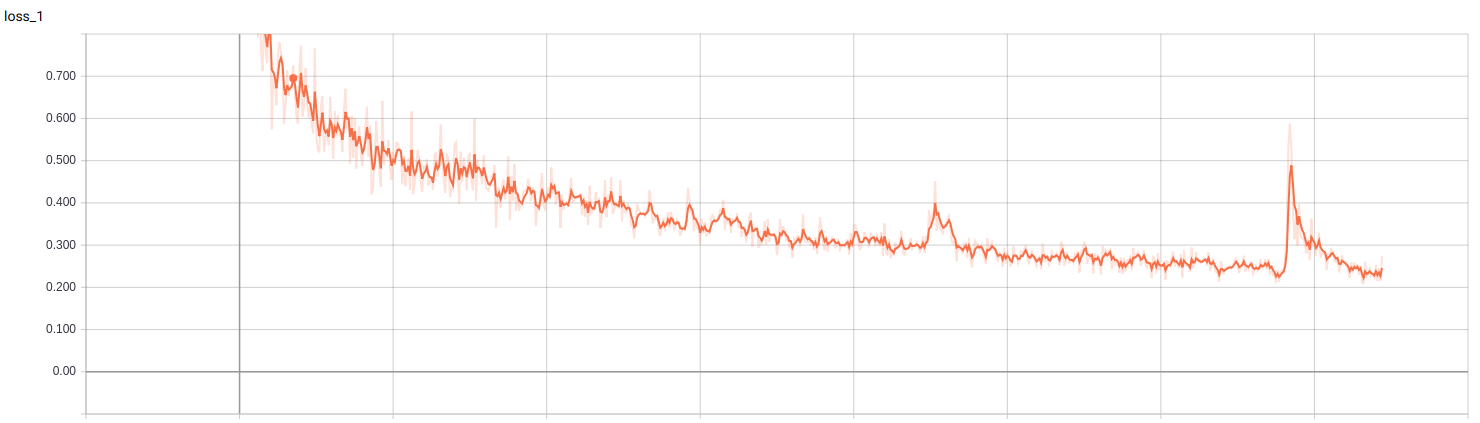

# Try to predict one image

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
test_image1='/home/huizeng/Hui_Zeng_Computer_Learning/cityscapes_dataset/leftImg8bit_trainvaltest/leftImg8bit/test/berlin/berlin_000000_000019_leftImg8bit.png'
test_image1 = scipy.misc.imread(test_image1)

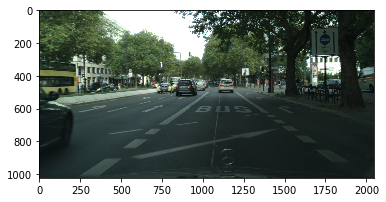

In [23]:
plt.imshow(test_image1)

In [26]:
args = {}

args['action'] = 'predict'  # choices=['train','predict', 'freeze', 'optimise', 'video']
args['gpu'] = 0   #'number of GPUs to use. default 0 (use CPU)', type=int, default=0
args['gpu_mem'] = 0.9   #'GPU memory fraction to use. default 0.9', type=float, default=0.9
args['xla'] = None   #'XLA JIT level. default None', type=int, default=None, choices=[1,2]
args['epochs'] = 10  #'training epochs. default 0', type=int, default=0)
args['batch_size'] = 5  #'training batch size. default 5', type=int, default=5
args['learning_rate'] = 0.0001  #'training learning rate. default 0.0001', type=float, default=0.0001
args['keep_prob'] = 0.9   #'training dropout keep probability. default 0.9', type=float, default=0.9
args['runs_dir'] = 'cityscapes_runs'   #'training runs directory. default runs', type=str, default='runs'
args['ckpt_dir'] = 'cityscapes_ckpt'   #'training checkpoints directory. default ckpt', type=str, default='ckpt'
args['summary_dir'] = 'cityscapes_summaries'  #'training tensorboard summaries directory. default summaries', type=str, default='summaries'
args['model_dir'] = 'cityscapes_runs/20190107_104200/model'    #'model directory. default None - model directory is created in runs. needed for predict', type=str, default=None)
args['frozen_model_dir'] = None    #'model directory for frozen graph. for freeze', type=str, default=None
args['optimised_model_dir'] = None   #'model directory for optimised graph. for optimize', type=str, default=None
args['images_paths'] = '/home/huizeng/Hui_Zeng_Computer_Learning/cityscapes_dataset/leftImg8bit_trainvaltest/leftImg8bit/test/berlin/berlin_000000_000019_leftImg8bit.png'    #"images path/file pattern. e.g. 'train/img*.png'", type=str, default=None
args['labels_paths'] = None    #"label images path/file pattern. e.g. 'train/label*.png'", type=str, default=None
args['video_file_in'] = None   #"mp4 video file to process", type=str, default=None
args['video_file_out'] = None  #"mp4 video file to save results", type=str, default=None

In [27]:
implementation(**args)

TensorFlow Version: 1.9.0
Default GPU Device: /device:GPU:0
action=predict
gpu=0
images_paths=/home/huizeng/Hui_Zeng_Computer_Learning/cityscapes_dataset/leftImg8bit_trainvaltest/leftImg8bit/test/berlin/berlin_000000_000019_leftImg8bit.png
INFO:tensorflow:Restoring parameters from cityscapes_runs/20190107_104200/model/variables/variables


Predicting (last tf call __ ms):   0%|          | 0/1 [00:00<?, ?images/s]

Predicting on test images /home/huizeng/Hui_Zeng_Computer_Learning/cityscapes_dataset/leftImg8bit_trainvaltest/leftImg8bit/test/berlin/berlin_000000_000019_leftImg8bit.png to: cityscapes_runs/20190107_210638


Predicting (last tf call 320 ms, avg tf 0 ms, last img 110 ms, avg 0 ms): 100%|██████████| 1/1 [00:00<00:00,  1.81images/s]


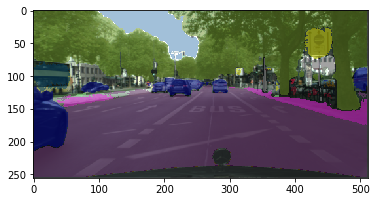

In [28]:
test_prediction1 = 'cityscapes_runs/20190107_210638/berlin_000000_000019_leftImg8bit.png'
test_prediction1 = scipy.misc.imread(test_prediction1)
plt.imshow(test_prediction1)

# Inference on all test images.

In [29]:
args = {}

args['action'] = 'predict'  # choices=['train','predict', 'freeze', 'optimise', 'video']
args['gpu'] = 0   #'number of GPUs to use. default 0 (use CPU)', type=int, default=0
args['gpu_mem'] = 0.9   #'GPU memory fraction to use. default 0.9', type=float, default=0.9
args['xla'] = None   #'XLA JIT level. default None', type=int, default=None, choices=[1,2]
args['epochs'] = 10  #'training epochs. default 0', type=int, default=0)
args['batch_size'] = 5  #'training batch size. default 5', type=int, default=5
args['learning_rate'] = 0.0001  #'training learning rate. default 0.0001', type=float, default=0.0001
args['keep_prob'] = 0.9   #'training dropout keep probability. default 0.9', type=float, default=0.9
args['runs_dir'] = 'cityscapes_runs'   #'training runs directory. default runs', type=str, default='runs'
args['ckpt_dir'] = 'cityscapes_ckpt'   #'training checkpoints directory. default ckpt', type=str, default='ckpt'
args['summary_dir'] = 'cityscapes_summaries'  #'training tensorboard summaries directory. default summaries', type=str, default='summaries'
args['model_dir'] = 'cityscapes_runs/20190107_104200/model'    #'model directory. default None - model directory is created in runs. needed for predict', type=str, default=None)
args['frozen_model_dir'] = None    #'model directory for frozen graph. for freeze', type=str, default=None
args['optimised_model_dir'] = None   #'model directory for optimised graph. for optimize', type=str, default=None
args['images_paths'] = None #"images path/file pattern. e.g. 'train/img*.png'", type=str, default=None
args['labels_paths'] = None    #"label images path/file pattern. e.g. 'train/label*.png'", type=str, default=None
args['video_file_in'] = None   #"mp4 video file to process", type=str, default=None
args['video_file_out'] = None  #"mp4 video file to save results", type=str, default=None

In [30]:
implementation(**args)

TensorFlow Version: 1.9.0
Default GPU Device: /device:GPU:0
action=predict
gpu=0
images_paths=/home/huizeng/Hui_Zeng_Computer_Learning/cityscapes_dataset/leftImg8bit_trainvaltest/leftImg8bit/test/*/*.png
INFO:tensorflow:Restoring parameters from cityscapes_runs/20190107_104200/model/variables/variables


Predicting (last tf call __ ms):   0%|          | 0/1525 [00:00<?, ?images/s]

Predicting on test images /home/huizeng/Hui_Zeng_Computer_Learning/cityscapes_dataset/leftImg8bit_trainvaltest/leftImg8bit/test/*/*.png to: cityscapes_runs/20190107_211332


Predicting (last tf call 32 ms, avg tf 30 ms, last img 167 ms, avg 117 ms): 100%|██████████| 1525/1525 [08:09<00:00,  2.86images/s]


# Inference on my own video.

In [36]:
!pwd

/home/huizeng/Hui_Zeng_Computer_Learning/Self_driving_engineer_nanodegree/Term3/CarND-Semantic-Segmentation


In [37]:
!ls

 cityscapes_ckpt			    main_Kitti_Road_dataset.py
 cityscapes_runs			    near_home.MOV
' cityscapes_semantic_segmentation.ipynb'   near_home.mp4
 cityscapes_summaries			    project_tests.py
 data					    __pycache__
 data_road.zip				    README.md
 examples				    runs
 helper.py				    set_git.sh
 LICENSE				    vgg.zip


In [35]:
# convert mov file to mp4 file
!ffmpeg -i near_home.MOV -codec copy near_home.mp4

ffmpeg version 3.4.4-0ubuntu0.18.04.1 Copyright (c) 2000-2018 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --ena

In [38]:
args = {}

args['action'] = 'video'  # choices=['train','predict', 'freeze', 'optimise', 'video']
args['gpu'] = 0   #'number of GPUs to use. default 0 (use CPU)', type=int, default=0
args['gpu_mem'] = 0.9   #'GPU memory fraction to use. default 0.9', type=float, default=0.9
args['xla'] = None   #'XLA JIT level. default None', type=int, default=None, choices=[1,2]
args['epochs'] = 10  #'training epochs. default 0', type=int, default=0)
args['batch_size'] = 5  #'training batch size. default 5', type=int, default=5
args['learning_rate'] = 0.0001  #'training learning rate. default 0.0001', type=float, default=0.0001
args['keep_prob'] = 0.9   #'training dropout keep probability. default 0.9', type=float, default=0.9
args['runs_dir'] = 'cityscapes_runs'   #'training runs directory. default runs', type=str, default='runs'
args['ckpt_dir'] = 'cityscapes_ckpt'   #'training checkpoints directory. default ckpt', type=str, default='ckpt'
args['summary_dir'] = 'cityscapes_summaries'  #'training tensorboard summaries directory. default summaries', type=str, default='summaries'
args['model_dir'] = 'cityscapes_runs/20190107_104200/model'    #'model directory. default None - model directory is created in runs. needed for predict', type=str, default=None)
args['frozen_model_dir'] = None    #'model directory for frozen graph. for freeze', type=str, default=None
args['optimised_model_dir'] = None   #'model directory for optimised graph. for optimize', type=str, default=None
args['images_paths'] = None #"images path/file pattern. e.g. 'train/img*.png'", type=str, default=None
args['labels_paths'] = None    #"label images path/file pattern. e.g. 'train/label*.png'", type=str, default=None
args['video_file_in'] = 'near_home.mp4'   #"mp4 video file to process", type=str, default=None
args['video_file_out'] = 'near_home_segmented.mp4'  #"mp4 video file to save results", type=str, default=None

In [39]:
implementation(**args)

TensorFlow Version: 1.9.0
Default GPU Device: /device:GPU:0
action=video
gpu=0
INFO:tensorflow:Restoring parameters from cityscapes_runs/20190107_104200/model/variables/variables
Running on video near_home.mp4, output to: near_home_segmented.mp4
[MoviePy] >>>> Building video near_home_segmented.mp4
[MoviePy] Writing video near_home_segmented.mp4


100%|█████████▉| 3540/3541 [16:20<00:00,  3.62it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: near_home_segmented.mp4 

